In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [41]:
class Layer:

    def __init__(self, num_neurons, num_arg, activate_fun, number):
        # normal distribution
        # self.weight_array = np.random.uniform(0, 1, (num_neurons, num_arg))
        # self.bias_array = np.random.uniform(0, 1, (num_neurons, 1))
        
        # He (Kaiming Initialization)
        self.weight_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, num_arg))
        self.bias_array = np.random.normal(0, math.sqrt(2/num_arg), (num_neurons, 1))
        self.activate_fun = activate_fun
        self.last_activation = None
        self.last_argument = None


    def forward(self, arguments_array):
        f = self.weight_array @ arguments_array + self.bias_array
        g = self.activate_fun(f)
        self.last_activation = g.copy()
        self.last_argument = arguments_array.copy()
        return g

class Network:

    def __init__(self, size_layers, size_input, activate_fun_array):
        self.size_layers = size_layers
        self.size_input = size_input

        num_arg = [size_input] + size_layers
        self.layers = [Layer(size_layers[i], num_arg[i], activate_fun_array[i], i) for i in range(len(size_layers))]
        self.mse_list = []


    def forward(self, arguments_array):
        for layer in self.layers:
            arguments_array = layer.forward(arguments_array)
        return arguments_array
    
    
    def backprop(self, x, y, eta):
        y_hat = self.forward(x)
        dL_dg = (y_hat - y)
        dL_df = dL_dg
        dL_dw = dL_df @ self.layers[-1].last_argument.T
        dL_db = dL_df
        self.layers[-1].weight_array -= (eta * dL_dw / x.shape[1]).copy()
        self.layers[-1].bias_array -= ((eta * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
        dL_dg = self.layers[-1].weight_array.T @ dL_df
        for layer in reversed(self.layers[:-1]):
            dL_df = dL_dg * (layer.last_activation * (1 - layer.last_activation))
            dL_dw = dL_df @ layer.last_argument.T
            dL_db = dL_df
            layer.weight_array -= (eta * dL_dw / x.shape[1]).copy()
            layer.bias_array -= ((eta * np.sum(dL_db, axis=1) / x.shape[1]).reshape(-1, 1)).copy()
            dL_dg = layer.weight_array.T @ dL_df
            
            
    def mini_batches(self, X, Y, batch_size):
        num_samples = X.shape[1]
        
        new_index = np.arange(num_samples)
        np.random.shuffle(new_index)
        X_shuffled = X[:, new_index]
        Y_shuffled = Y[:, new_index]
        
        for start_ind in range(0, num_samples, batch_size):
            end_ind = min(start_ind + batch_size, num_samples)
            yield X_shuffled[:, start_ind:end_ind], Y_shuffled[:, start_ind:end_ind]
        
    
    
    def train(self, X, Y, epochs, eta, batch_size):
        for epoch in range(epochs):
            for x_batch, y_batch in self.mini_batches(X, Y, batch_size):
                self.backprop(x_batch, y_batch, eta)
                
            y_hat_ = self.forward(X)
            mse = np.mean((y_hat_ - Y) ** 2)
            self.mse_list.append(mse)
            if epoch % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, MSE = {mse:.4f}")


    def visualise_weights(self):
        matrices = [self.layers[m].weight_array for m in range(len(self.layers))]
        total_width = sum([mat.shape[1] for mat in matrices]) * 2
        max_height = max([mat.shape[0] for mat in matrices]) * 2

        plt.figure(figsize=(total_width, max_height))

        for m, mat in enumerate(matrices):
            plt.subplot(1, len(matrices), m + 1)
            ax = sns.heatmap(mat, annot=True, cmap='viridis', square=True, cbar=False, annot_kws={"fontsize":18})
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.title(f'Layer {m + 1}')

        plt.tight_layout()
        plt.show()
    
    
    def visualise_as_strip(self, title):
        arrays = [self.layers[m].weight_array for m in range(len(self.layers))]
        flattened_array = np.concatenate([arr.flatten() for arr in arrays])
        plt.figure(figsize=(len(flattened_array), 5))
        ax = sns.heatmap(flattened_array.reshape(1, -1), annot=True, cmap='viridis', square=True, cbar=False)
        ax.tick_params(left=False, bottom=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.title(title)
        plt.show()


def sigmoid(v):
    v = v.astype(np.longdouble)
    # return np.exp(v) / (np.exp(v) + 1)
    return 1.0 / (1.0 + np.exp(-v))


def linear(v):
    v = v.astype(np.longdouble)
    return v

## Square simple

In [42]:
ss_train = pd.read_csv('NN\\regression\\square-simple-training.csv', dtype=np.longdouble)

In [43]:
X = ss_train['x'].values.reshape(1, -1)
y = ss_train['y'].values.reshape(1, -1)

In [44]:
layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.train(X=X, Y=y, epochs=5000, eta=0.01, batch_size=X.shape[1])
mse1 = N.mse_list

Epoch 1/5000, MSE = 9797.4783
Epoch 101/5000, MSE = 2188.1768
Epoch 201/5000, MSE = 618.6022
Epoch 301/5000, MSE = 232.8837
Epoch 401/5000, MSE = 114.4182
Epoch 501/5000, MSE = 71.2817
Epoch 601/5000, MSE = 49.4687
Epoch 701/5000, MSE = 35.9276
Epoch 801/5000, MSE = 27.2096
Epoch 901/5000, MSE = 21.5344
Epoch 1001/5000, MSE = 17.6776
Epoch 1101/5000, MSE = 14.9242
Epoch 1201/5000, MSE = 12.8663
Epoch 1301/5000, MSE = 11.2595
Epoch 1401/5000, MSE = 9.9452
Epoch 1501/5000, MSE = 8.8182
Epoch 1601/5000, MSE = 7.8286
Epoch 1701/5000, MSE = 6.9767
Epoch 1801/5000, MSE = 6.2619
Epoch 1901/5000, MSE = 5.6643
Epoch 2001/5000, MSE = 5.1621
Epoch 2101/5000, MSE = 4.7377
Epoch 2201/5000, MSE = 4.3759
Epoch 2301/5000, MSE = 4.0635
Epoch 2401/5000, MSE = 3.7900
Epoch 2501/5000, MSE = 3.5476
Epoch 2601/5000, MSE = 3.3303
Epoch 2701/5000, MSE = 3.1339
Epoch 2801/5000, MSE = 2.9551
Epoch 2901/5000, MSE = 2.7913
Epoch 3001/5000, MSE = 2.6406
Epoch 3101/5000, MSE = 2.5016
Epoch 3201/5000, MSE = 2.3729
E

In [45]:
layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.train(X=X, Y=y, epochs=5000, eta=0.01, batch_size=32)
mse2 = N.mse_list

Epoch 1/5000, MSE = 8856.2022
Epoch 101/5000, MSE = 110.2202
Epoch 201/5000, MSE = 23.9464
Epoch 301/5000, MSE = 15.0749
Epoch 401/5000, MSE = 9.1566
Epoch 501/5000, MSE = 34.8128
Epoch 601/5000, MSE = 9.2212
Epoch 701/5000, MSE = 2.6584
Epoch 801/5000, MSE = 2.8114
Epoch 901/5000, MSE = 2.2022
Epoch 1001/5000, MSE = 1.4635
Epoch 1101/5000, MSE = 1.5960
Epoch 1201/5000, MSE = 1.3964
Epoch 1301/5000, MSE = 2.0488
Epoch 1401/5000, MSE = 0.8162
Epoch 1501/5000, MSE = 0.8465
Epoch 1601/5000, MSE = 1.2396
Epoch 1701/5000, MSE = 1.7469
Epoch 1801/5000, MSE = 0.5290
Epoch 1901/5000, MSE = 2.5867
Epoch 2001/5000, MSE = 0.6474
Epoch 2101/5000, MSE = 0.5961
Epoch 2201/5000, MSE = 0.3952
Epoch 2301/5000, MSE = 0.4283
Epoch 2401/5000, MSE = 0.9166
Epoch 2501/5000, MSE = 0.4634
Epoch 2601/5000, MSE = 0.3173
Epoch 2701/5000, MSE = 0.4880
Epoch 2801/5000, MSE = 0.2725
Epoch 2901/5000, MSE = 0.2647
Epoch 3001/5000, MSE = 1.0354
Epoch 3101/5000, MSE = 0.3200
Epoch 3201/5000, MSE = 0.8562
Epoch 3301/500

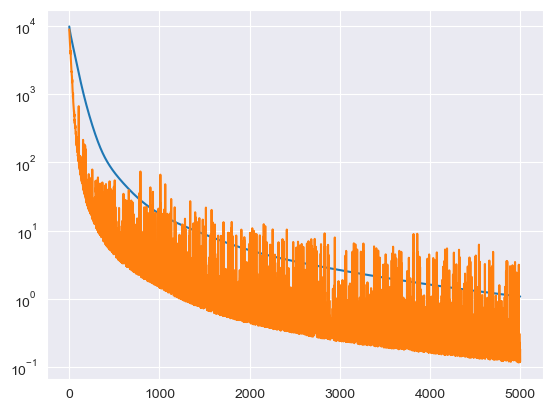

In [47]:
plt.yscale('log')
plt.plot(mse1)
plt.plot(mse2)

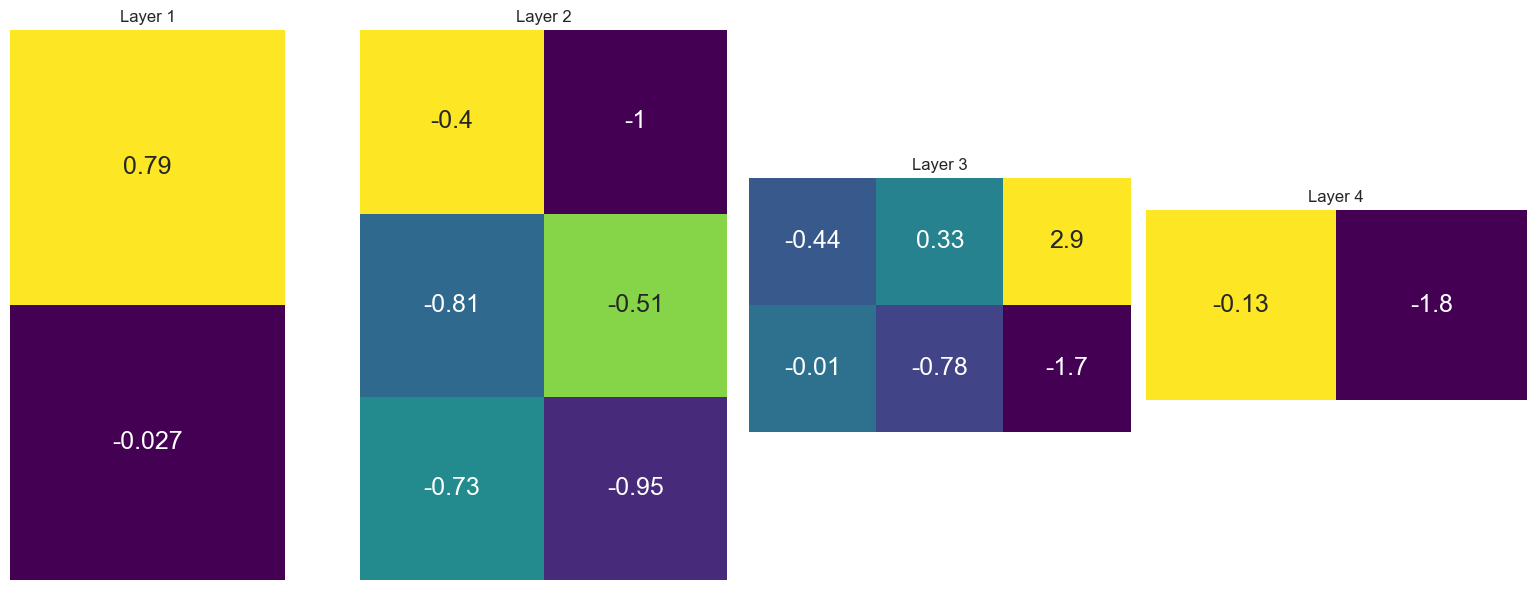

Epoch 1/1000, MSE = 9836.6662
Epoch 101/1000, MSE = 9173.3808
Epoch 201/1000, MSE = 9179.1145
Epoch 301/1000, MSE = 6689.2541
Epoch 401/1000, MSE = 4634.4251
Epoch 501/1000, MSE = 10215.4510
Epoch 601/1000, MSE = 8736.8475
Epoch 701/1000, MSE = 8674.5245
Epoch 801/1000, MSE = 9184.6671
Epoch 901/1000, MSE = 9187.3941


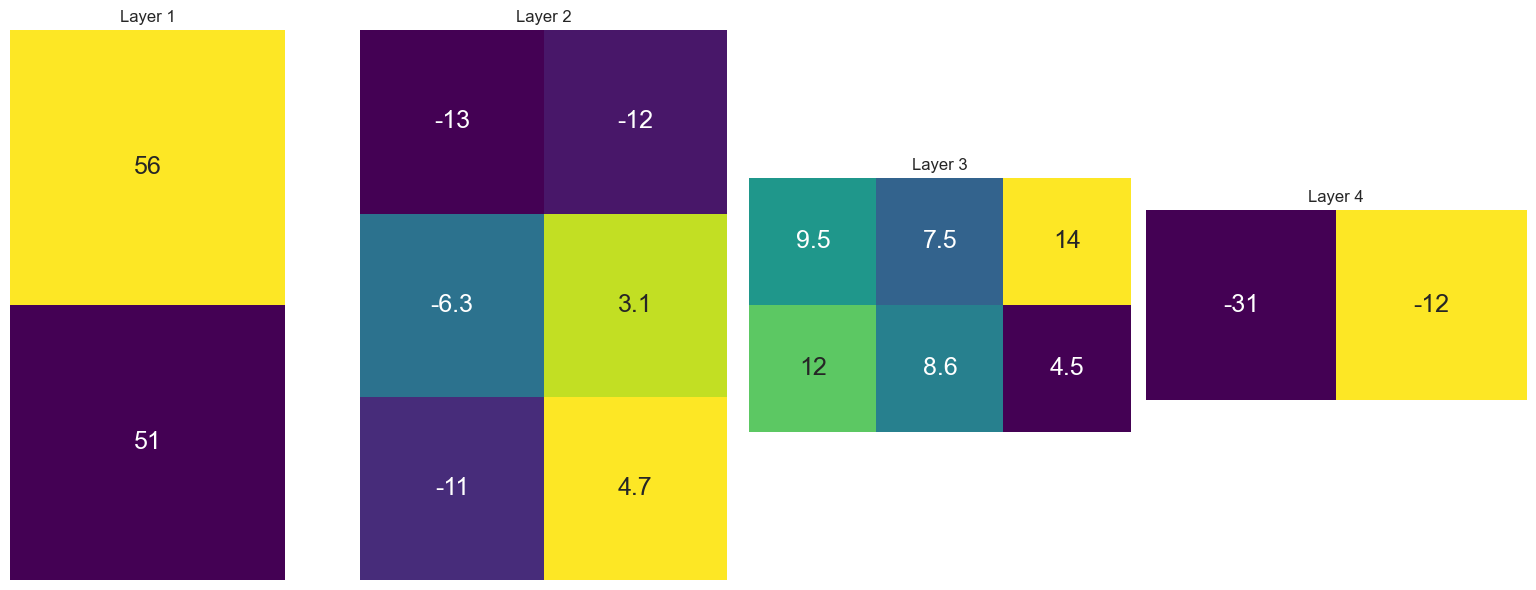

In [48]:
layers = [2, 3, 2, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.visualise_weights()
N.train(X=X, Y=y, epochs=1000, eta=0.01, batch_size=32)
N.visualise_weights()

## Steps small

Epoch 1/100000, MSE = 6283.6539
Epoch 101/100000, MSE = 467.9745
Epoch 201/100000, MSE = 375.4549
Epoch 301/100000, MSE = 348.9503
Epoch 401/100000, MSE = 337.2414
Epoch 501/100000, MSE = 330.0800
Epoch 601/100000, MSE = 324.4566
Epoch 701/100000, MSE = 319.3241
Epoch 801/100000, MSE = 314.2949
Epoch 901/100000, MSE = 309.0812
Epoch 1001/100000, MSE = 303.2536
Epoch 1101/100000, MSE = 296.8154
Epoch 1201/100000, MSE = 289.5643
Epoch 1301/100000, MSE = 281.5137
Epoch 1401/100000, MSE = 272.8983
Epoch 1501/100000, MSE = 263.9346
Epoch 1601/100000, MSE = 254.7623
Epoch 1701/100000, MSE = 245.4749
Epoch 1801/100000, MSE = 236.1418
Epoch 1901/100000, MSE = 226.8214
Epoch 2001/100000, MSE = 217.5653
Epoch 2101/100000, MSE = 208.4254
Epoch 2201/100000, MSE = 199.4689
Epoch 2301/100000, MSE = 190.7728
Epoch 2401/100000, MSE = 182.3996
Epoch 2501/100000, MSE = 174.3936
Epoch 2601/100000, MSE = 166.7892
Epoch 2701/100000, MSE = 159.6113
Epoch 2801/100000, MSE = 152.8703
Epoch 2901/100000, MSE = 

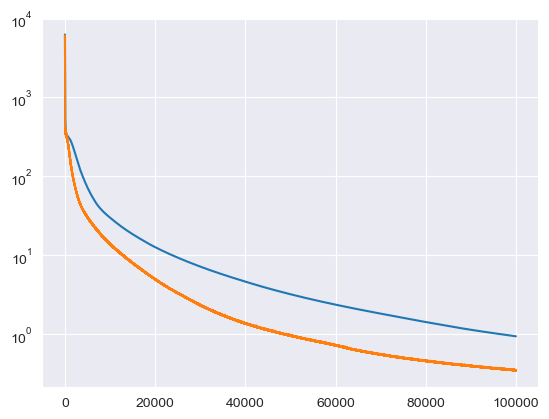

In [52]:
ss_train = pd.read_csv('NN\\regression\\steps-small-training.csv', dtype=np.longdouble)
X = ss_train['x'].values.reshape(1, -1)
y = ss_train['y'].values.reshape(1, -1)

# whole data
layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.train(X=X, Y=y, epochs=100000, eta=0.01, batch_size=X.shape[1])
mse1 = N.mse_list

# batch
layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.train(X=X, Y=y, epochs=100000, eta=0.01, batch_size=32)
mse2 = N.mse_list

print(f'MSE1 = {mse1[-1]}, MSE2 = {mse2[-1]}')

plt.yscale('log')
plt.plot(mse1)
plt.plot(mse2)

## Multimodal large

In [59]:
ss_train = pd.read_csv('NN\\regression\\multimodal-large-training.csv', dtype=np.longdouble)
X = ss_train['x'].values.reshape(1, -1)
y = ss_train['y'].values.reshape(1, -1)

layers = [50, 1]
fun_activation = [sigmoid for k in range(len(layers) - 1)] + [linear]
N = Network(size_layers=layers, size_input=1, activate_fun_array=fun_activation)

N.train(X=X, Y=y, epochs=1000, eta=0.01, batch_size=64)

Epoch 1/1000, MSE = 3008.4037
Epoch 101/1000, MSE = 34.2500
Epoch 201/1000, MSE = 12.2438
Epoch 301/1000, MSE = 9.4543
Epoch 401/1000, MSE = 8.2940
Epoch 501/1000, MSE = 7.7085
Epoch 601/1000, MSE = 7.3930
Epoch 701/1000, MSE = 7.2415
Epoch 801/1000, MSE = 7.0342
Epoch 901/1000, MSE = 7.0936


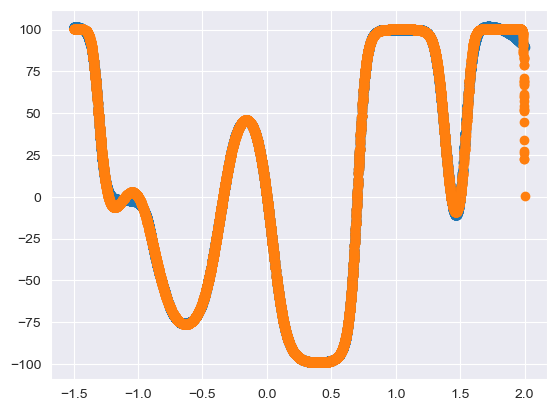

In [60]:
y = [N.forward(ss_train['x'].values[i].reshape(1, 1))[0][0] for i in range(len(ss_train['x'].values))]
plt.scatter(ss_train['x'], y)
plt.scatter(ss_train['x'], ss_train['y'])